In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# The parameter names must match the pipeline step names, e.g., 'classifier__max_depth'
# Define base models (Decision Tree, kNN, Logistic Regression)

param_grid_dt = {
    'selectkbest__k': [5, 10, 15, 'all'],
    'classifier__max_depth': [None, 3, 5, 8],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_knn = {
    'selectkbest__k': [5, 10, 15, 'all'],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

param_grid_lr = {
    'selectkbest__k': [5, 10, 15, 'all'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__max_iter': [500]
}

# Create a list of (classifier, param_grid, name) tuples
classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, 'Decision Tree'),
    (KNeighborsClassifier(), param_grid_knn, 'kNN'),
    (LogisticRegression(random_state=42), param_grid_lr, 'Logistic Regression')
]


In [3]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

In [15]:

X_train, X_test, y_train, y_test, dataset_name = load_wine_quality()


Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)


In [4]:
def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # 1. Adjust 'k' so it does not exceed number of features
        adjusted_grid = {}
        for k, v in param_grid.items():
            if k.startswith("selectkbest__k"):
                adjusted_grid[k] = [vv if vv == 'all' or vv <= n_features else n_features for vv in v]
            else:
                adjusted_grid[k] = v

        # 2. Generate all parameter combinations
        param_keys = list(adjusted_grid.keys())
        param_combos = list(itertools.product(*(adjusted_grid[k] for k in param_keys)))

        for combo in param_combos:
            params = dict(zip(param_keys, combo))
            aucs = []

            # 3. Cross-validation
            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                # Handle 'k'
                k_val = params['selectkbest__k']
                k_final = n_features if k_val == 'all' else k_val

                # Pipeline
                pipe = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(score_func=f_classif, k=k_final)),
                    ('classifier', classifier_instance.__class__())
                ])
                pipe.set_params(**{p: v for p, v in params.items() if p != 'selectkbest__k'})

                pipe.fit(X_tr, y_tr)
                if hasattr(pipe.named_steps['classifier'], "predict_proba"):
                    probs = pipe.predict_proba(X_val)[:,1]
                else:
                    probs = pipe.decision_function(X_val)

                auc = roc_auc_score(y_val, probs)
                aucs.append(auc)

            mean_auc = np.mean(aucs)
            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params

        print("-" * 90)
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        # Final pipeline with best parameters
        k_val = best_params['selectkbest__k']
        k_final = n_features if k_val == 'all' else k_val
        final_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=k_final)),
            ('classifier', classifier_instance.__class__())
        ])
        final_pipeline.set_params(**{p: v for p, v in best_params.items() if p != 'selectkbest__k'})
        final_pipeline.fit(X_train, y_train)

        best_estimators[name] = final_pipeline

    return best_estimators


In [11]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # Adjust feature selection param grid so k does not exceed n_features
        adjusted_grid = {}
        for k, v in param_grid.items():
            if k.startswith("selectkbest__k"):
                adjusted_grid[k] = [vv if vv == "all" or vv <= n_features else n_features for vv in v]
            else:
                adjusted_grid[k] = v

        # Build pipeline
        pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selectkbest', SelectKBest(score_func=f_classif)),
    ('classifier', classifier_instance)
])


        # CV splitter
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_grid,
            cv=cv_splitter,
            scoring='roc_auc',
            n_jobs=-1,
            refit=True
        )

        grid_search.fit(X_train, y_train)

        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin


In [12]:
def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        # Create VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)  # Note: This assumes X_train, y_train are in scope

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

In [13]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_test, y_test, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_test, y_test, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)


################################################################################
PROCESSING DATASET: WINE QUALITY
################################################################################
Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)
------------------------------

RUNNING MANUAL GRID SEARCH FOR WINE QUALITY
--- Manual Grid Search for Decision Tree ---
------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'selectkbest__k': 5, 'classifier__max_depth': 5, 'classifier__min_samples_split': 5}
Best cross-validation AUC: 0.7832
--- Manual Grid Search for kNN ---
------------------------------------------------------------------------------------------
Best parameters for kNN: {'selectkbest__k': 5, 'classifier__n_neighbors': 7, 'classifier__weights': 'distance', 'classifier__p': 1}
Best cross-validation AUC: 0.8667
--- Manual Grid Search for

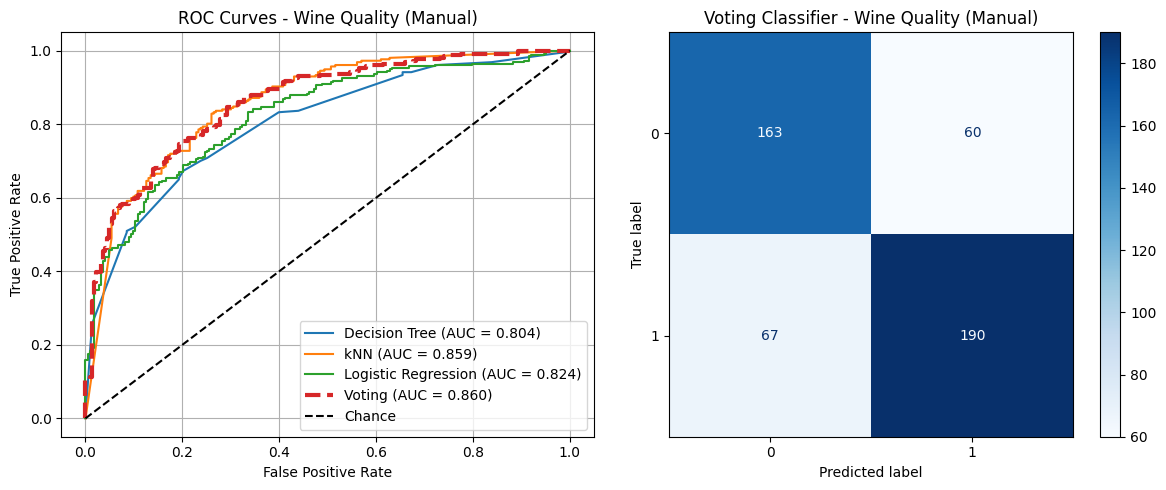


RUNNING BUILT-IN GRID SEARCH FOR WINE QUALITY

--- GridSearchCV for Decision Tree ---
Best params for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'selectkbest__k': 5}
Best CV score: 0.7832

--- GridSearchCV for kNN ---
Best params for kNN: {'classifier__n_neighbors': 7, 'classifier__p': 1, 'classifier__weights': 'distance', 'selectkbest__k': 5}
Best CV score: 0.8667

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 1, 'classifier__max_iter': 500, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'selectkbest__k': 11}
Best CV score: 0.8052

EVALUATING BUILT-IN MODELS FOR WINE QUALITY

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.7271
  Precision: 0.7716
  Recall: 0.6965
  F1-Score: 0.7321
  ROC AUC: 0.8025

kNN:
  Accuracy: 0.7812
  Precision: 0.7836
  Recall: 0.8171
  F1-Score: 0.8000
  ROC AUC: 0.8589

Logistic Regression:
  Accuracy: 0.7333
  Precision: 0.7549
  Reca

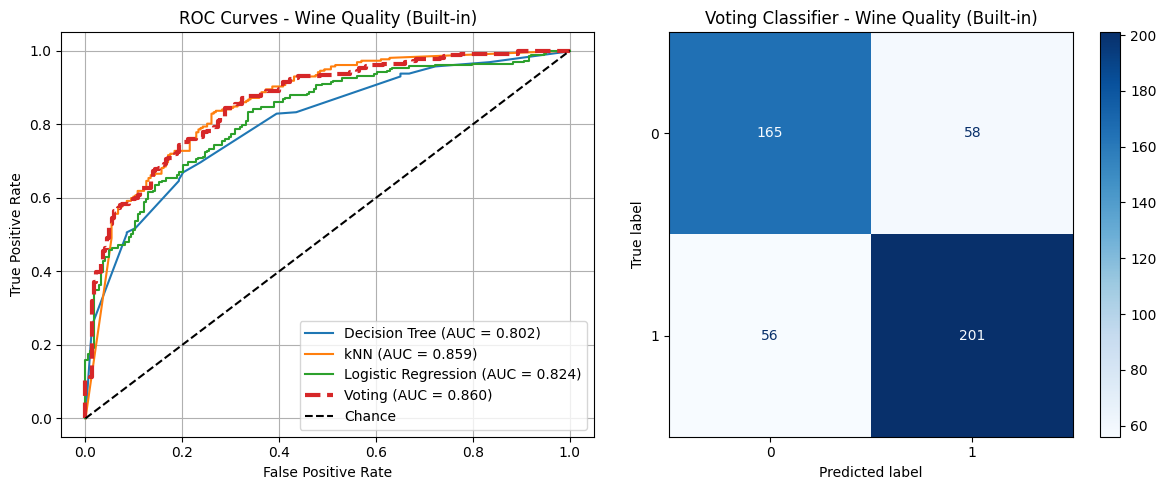


Completed processing for Wine Quality

ALL DATASETS PROCESSED!


In [14]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_wine_quality, "Wine Quality")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)